## Cone Classification Using Optical Feedback

In [15]:
import numpy as np
import matplotlib.pyplot as plt

## simulation imports
from cone import *
import opticalfeedback

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

<IPython.core.display.Javascript object>


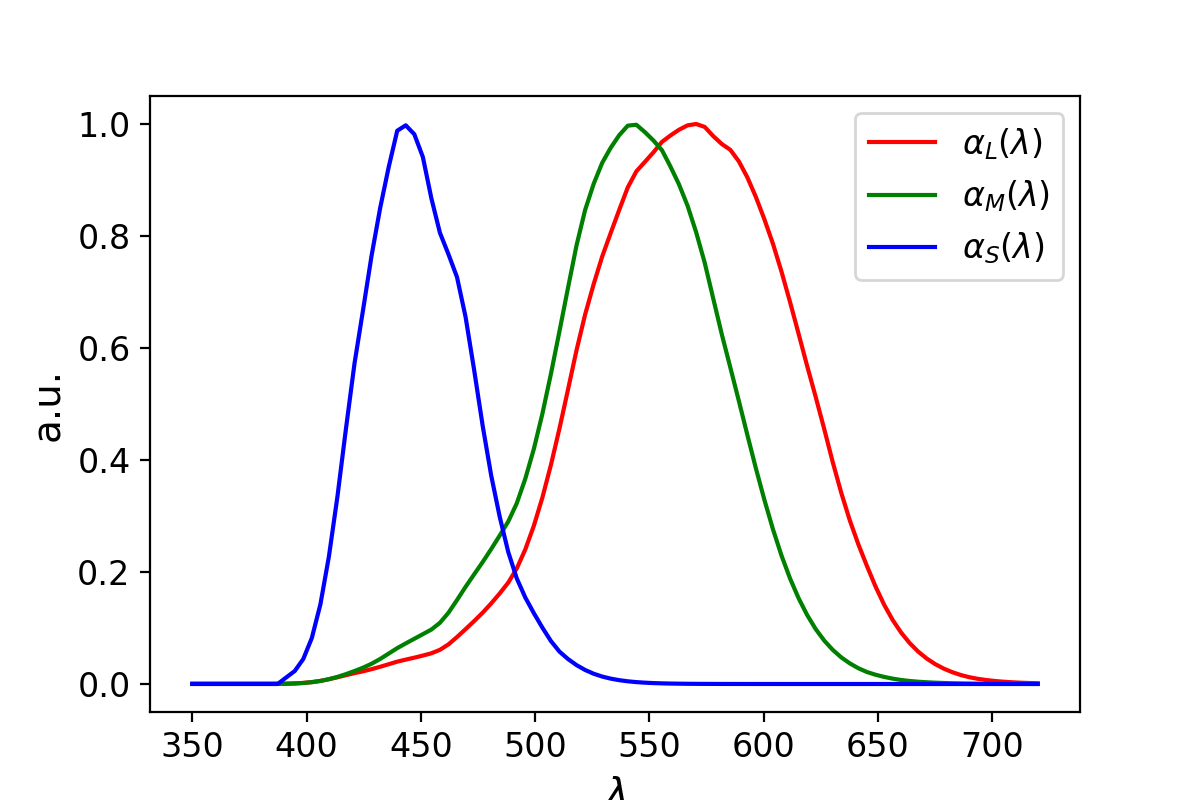

In [17]:
%matplotlib notebook
lmbdas = np.linspace(350,720,100)
lmbda = 625
c = cone('data/linss2_10e_fine.csv')

cL = list(map(c.cone_L,lmbdas))
cM = list(map(c.cone_M,lmbdas))
cS = list(map(c.cone_S,lmbdas))

fig,ax = plt.subplots(1,1,figsize=(6,4), dpi=100)
ax.plot(lmbdas,cL, 'red', label=r'$\alpha_{L}(\lambda)$')
ax.plot(lmbdas,cM, 'green', label=r'$\alpha_{M}(\lambda)$')
ax.plot(lmbdas,cS, 'blue', label=r'$\alpha_{S}(\lambda)$')
ax.set_xlabel('$\lambda$')
ax.set_ylabel('a.u.')
ax.legend()

## Demonstrate photopigment bleaching dynamics

In [18]:
%matplotlib notebook
n_on = 5
n_off = 195
pulse = ([1]*n_on) + ([0]*n_off)
pulse = pulse * 4
pulse = np.array(pulse)

step_size = 0.05
n_seconds = 40
t = np.arange(0, n_seconds, step_size)
p0 = 1.0
Qe = 3e6
Iin = 4e5*pulse
a_cone = c.cone_L(lmbda)
a_scatter = 0.95

Iout = []
pt = [p0]
p_ti = p0
for i, ti in enumerate(t):
    p_grad = dpdt(Iin[i], Qe, pt[i])
    p_ti += p_grad * step_size
    pt.append(p_ti)
    Iout.append(compute_reflected_light(Iin[i], a_cone, p_ti, a_scatter=a_scatter))

<IPython.core.display.Javascript object>


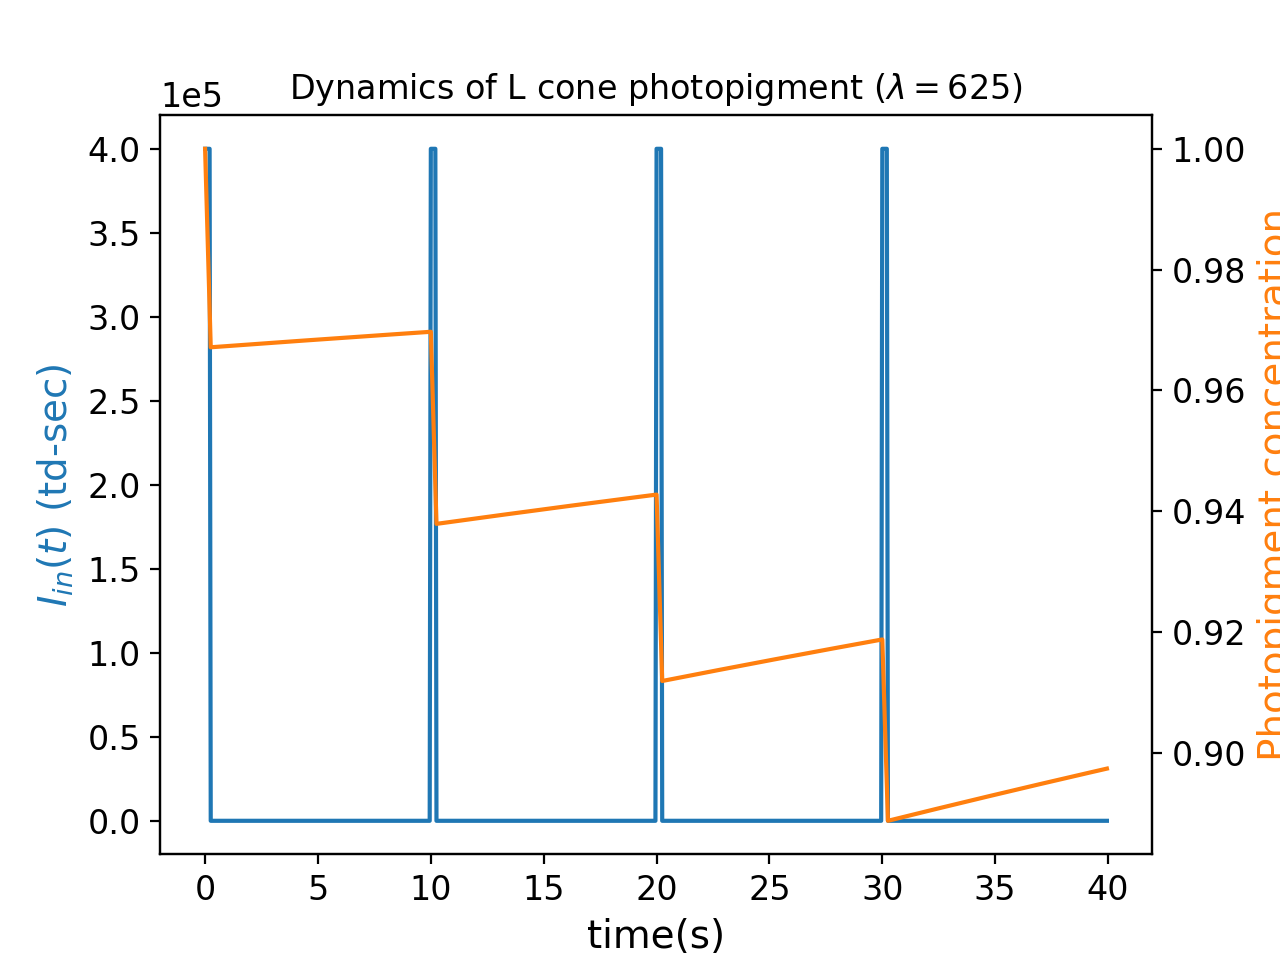

Text(0, 0.5, 'Photopigment concentration')

In [19]:
fig,ax = plt.subplots()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.plot(t, Iin, 'tab:blue')
ax.set_xlabel('time(s)')
ax.set_ylabel('$I_{in}(t)$ (td-sec)',color='tab:blue')
plt.title('Dynamics of L cone photopigment ($\lambda=%d$)'%(lmbda))

ax2=ax.twinx()
ax2.plot(t, pt[:-1],'tab:orange')
ax2.set_ylabel("Photopigment concentration",color='tab:orange')


<IPython.core.display.Javascript object>


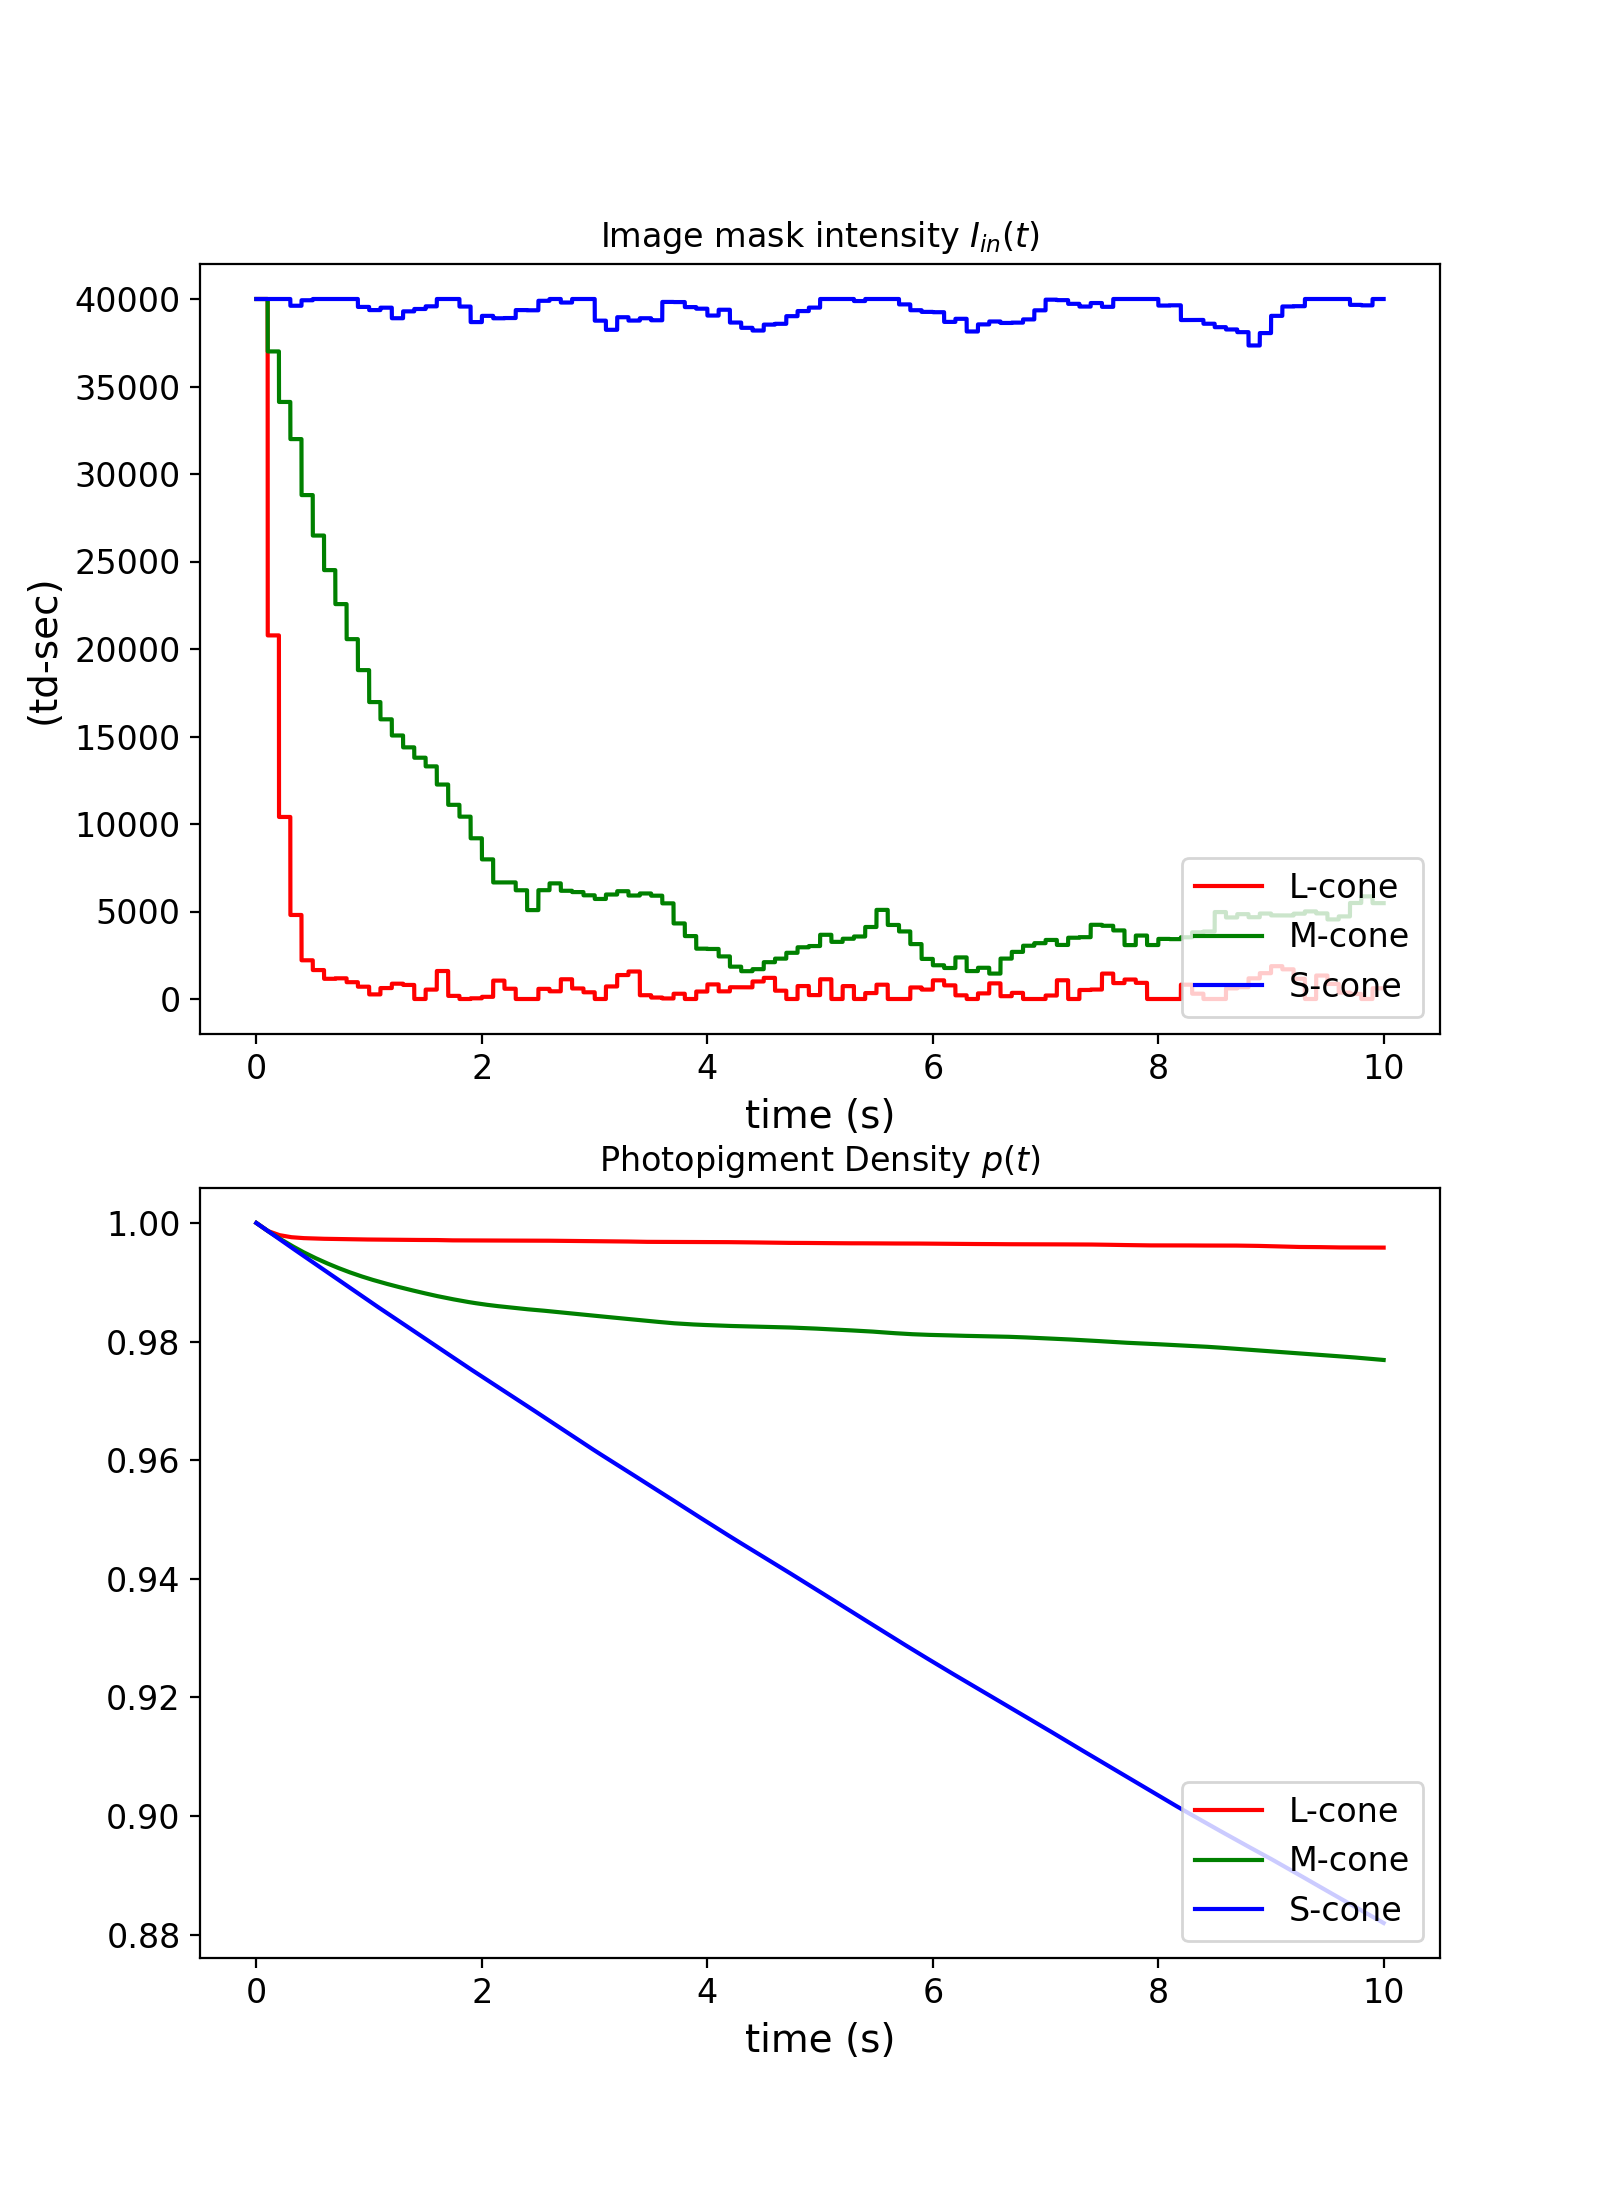

<IPython.core.display.Javascript object>


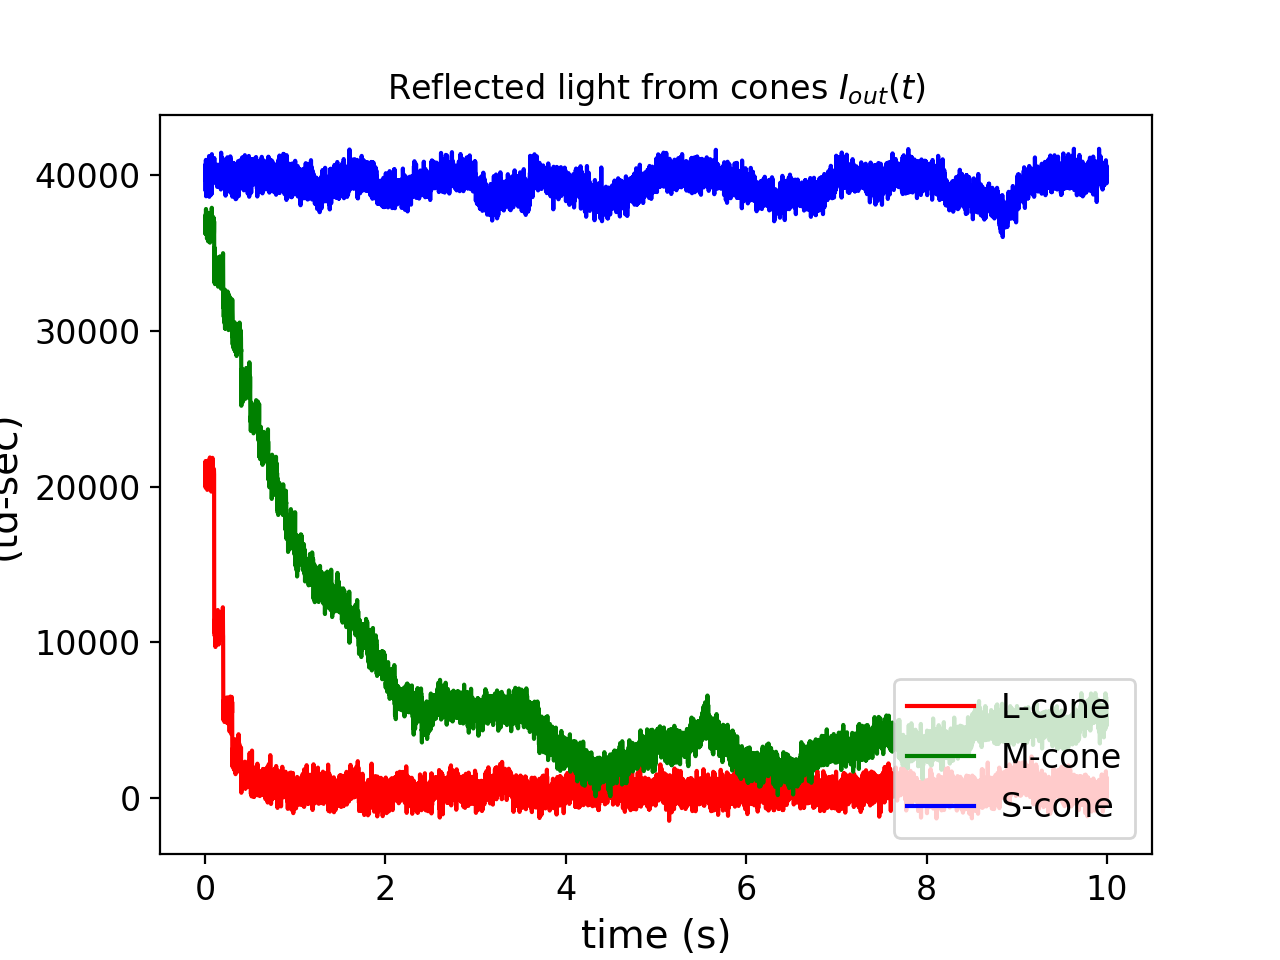

In [21]:
%matplotlib notebook


n_seconds   = 10     
a_scatter   = .995
Iin_0       = 4e4 

L_Iin, L_Iout, L_pt, t, _ = opticalfeedback.simulate(a_cone=c.cone_L(lmbda), n_seconds=n_seconds, \
                                                     a_scatter_bounds=(a_scatter,a_scatter), Iin_0=Iin_0)
M_Iin, M_Iout, M_pt, t, _ = opticalfeedback.simulate(a_cone=c.cone_M(lmbda), n_seconds=n_seconds, \
                                                     a_scatter_bounds=(a_scatter,a_scatter), Iin_0=Iin_0)
S_Iin, S_Iout, S_pt, t, _ = opticalfeedback.simulate(a_cone=c.cone_S(lmbda), n_seconds=n_seconds, \
                                                     a_scatter_bounds=(a_scatter,a_scatter), Iin_0=Iin_0)


plt.figure(figsize=(8, 11), dpi=100)
plt.subplot(2,1,1)
plt.plot(t, L_Iin[:-1],c='r')
plt.plot(t, M_Iin[:-1],c='g')
plt.plot(t, S_Iin[:-1],c='b')
plt.title('Image mask intensity $I_{in}(t)$')
plt.legend(['L-cone','M-cone','S-cone'],loc=4)
plt.xlabel('time (s)')
plt.ylabel('(td-sec)')

plt.subplot(2,1,2)
plt.plot(t, L_pt[:-1],c='r')
plt.plot(t, M_pt[:-1],c='g')
plt.plot(t, S_pt[:-1],c='b')
plt.title('Photopigment Density $p(t)$')
plt.legend(['L-cone','M-cone','S-cone'],loc=4)
plt.xlabel('time (s)')
plt.show()

plt.figure()
plt.plot(t, L_Iout,c='r')
plt.plot(t, M_Iout,c='g')
plt.plot(t, S_Iout,c='b')
plt.title('Reflected light from cones $I_{out}(t)$')
plt.legend(['L-cone','M-cone','S-cone'],loc=4)
plt.xlabel('time (s)')
plt.ylabel('(td-sec)')
plt.show()

# New stuff
## Infering intrinsic scatter

Given, 
$$I_{out}(t) = \alpha_{scatter} [ 1-\alpha_{cone}(\lambda)\cdot p(t) ]\cdot I_{in}(t) + \epsilon_m$$
If each cone is bleached $p(t)\rightarrow 0$,
$$I_{out}(t) = \alpha_{scatter} \cdot I_{in}(t) + \epsilon_m$$
We know $I_{in}$ (it is constant)
$$\mathbb{E}\left[\alpha_{scatter} \cdot I_{in} + \epsilon_m\right]$$
$$\mathbb{E}\left[\alpha_{scatter} \cdot I_{in} \right] + \mathbb{E}\left[\epsilon_m\right]$$

Assume we know $\mathbb{E}\left[\epsilon_m\right]$, and have $t=\{1,2,3,...,T\}$ samples of $I_{out}(t)$ (a random variable), estimate scatter via,

$$\hat{\alpha}_{scatter} = \sum_{t=1}^T\frac{I_{out}(t)-\mathbb{E}[\epsilon_m]}{I_{in}}$$


Now, using this estimate, we update the stimulus update equation accordingly. 

$$I_{out}(t) = \alpha_{scatter} [ 1-(\alpha_{cone}+\epsilon_{cone})\cdot p(t) ] \cdot I_{in}(t) + \epsilon_{m}$$

$$I_{in}(t+1):= \frac{I_{out}(t) -\mathbb{E}[\epsilon_m]}{\hat{\alpha}_{scatter}}$$

In [22]:
# simple helper functions
def append_four(a, b, c, d, all_a, all_b, all_c, all_d):
    # append 4 values to 4 lists
    all_a.append(a)
    all_b.append(b)
    all_c.append(c)
    all_d.append(d)
    
    
def convert_to_np(a,b,c,d):
    # convert four arrays to np.arrays
    return np.asarray(a), np.asarray(b), np.asarray(c), np.asarray(d)

## Run experiment without $\alpha_{scatter}$ estimation

In [24]:
# simulation settings
n_trials = 25

L_Iin_all, L_Iout_all, L_pt_all, L_resid_all = [],[],[],[]
M_Iin_all, M_Iout_all, M_pt_all, M_resid_all = [],[],[],[]
S_Iin_all, S_Iout_all, S_pt_all, S_resid_all = [],[],[],[]

for i in range(n_trials):
    lam = 222
    
    
    
    L_Iin, L_Iout, L_pt, t, L_resid = opticalfeedback.simulate(a_cone=c.cone_L(lmbda), account_for_a_scatter=False, \
                                                               a_scatter_bounds=(0.2,1))
    M_Iin, M_Iout, M_pt, t, M_resid = opticalfeedback.simulate(a_cone=c.cone_M(lmbda), account_for_a_scatter=False, \
                                                               a_scatter_bounds=(0.2,1))
    S_Iin, S_Iout, S_pt, t, S_resid = opticalfeedback.simulate(a_cone=c.cone_S(lmbda), account_for_a_scatter=False, \
                                                               a_scatter_bounds=(0.2,1))
    append_four(L_Iin, L_Iout, L_pt, L_resid, L_Iin_all, L_Iout_all, L_pt_all, L_resid_all)
    append_four(M_Iin, M_Iout, M_pt, M_resid, M_Iin_all, M_Iout_all, M_pt_all, M_resid_all)
    append_four(S_Iin, S_Iout, S_pt, S_resid, S_Iin_all, S_Iout_all, S_pt_all, S_resid_all)
    
L_Iin_all, L_Iout_all, L_pt_all, L_resid_all = convert_to_np(L_Iin_all, L_Iout_all, L_pt_all, L_resid_all)
M_Iin_all, M_Iout_all, M_pt_all, M_resid_all = convert_to_np(M_Iin_all, M_Iout_all, M_pt_all, M_resid_all)
S_Iin_all, S_Iout_all, S_pt_all, S_resid_all = convert_to_np(S_Iin_all, S_Iout_all, S_pt_all, S_resid_all)
    
print('L-cone intrinsic residual ~ mean: %0.2e ~ std: %0.2e' % 
      (np.mean(L_resid_all), np.std(L_resid_all)))
print('M-cone intrinsic residual ~ mean: %0.2e ~ std: %0.2e' % 
      (np.mean(M_resid_all), np.std(M_resid_all)))
print('S-cone intrinsic residual ~ mean: %0.2e ~ std: %0.2e' % 
      (np.mean(S_resid_all), np.std(S_resid_all)))

L-cone intrinsic residual ~ mean: 9.00e+09 ~ std: 0.00e+00
M-cone intrinsic residual ~ mean: 9.00e+09 ~ std: 0.00e+00
S-cone intrinsic residual ~ mean: 9.00e+09 ~ std: 0.00e+00


<IPython.core.display.Javascript object>


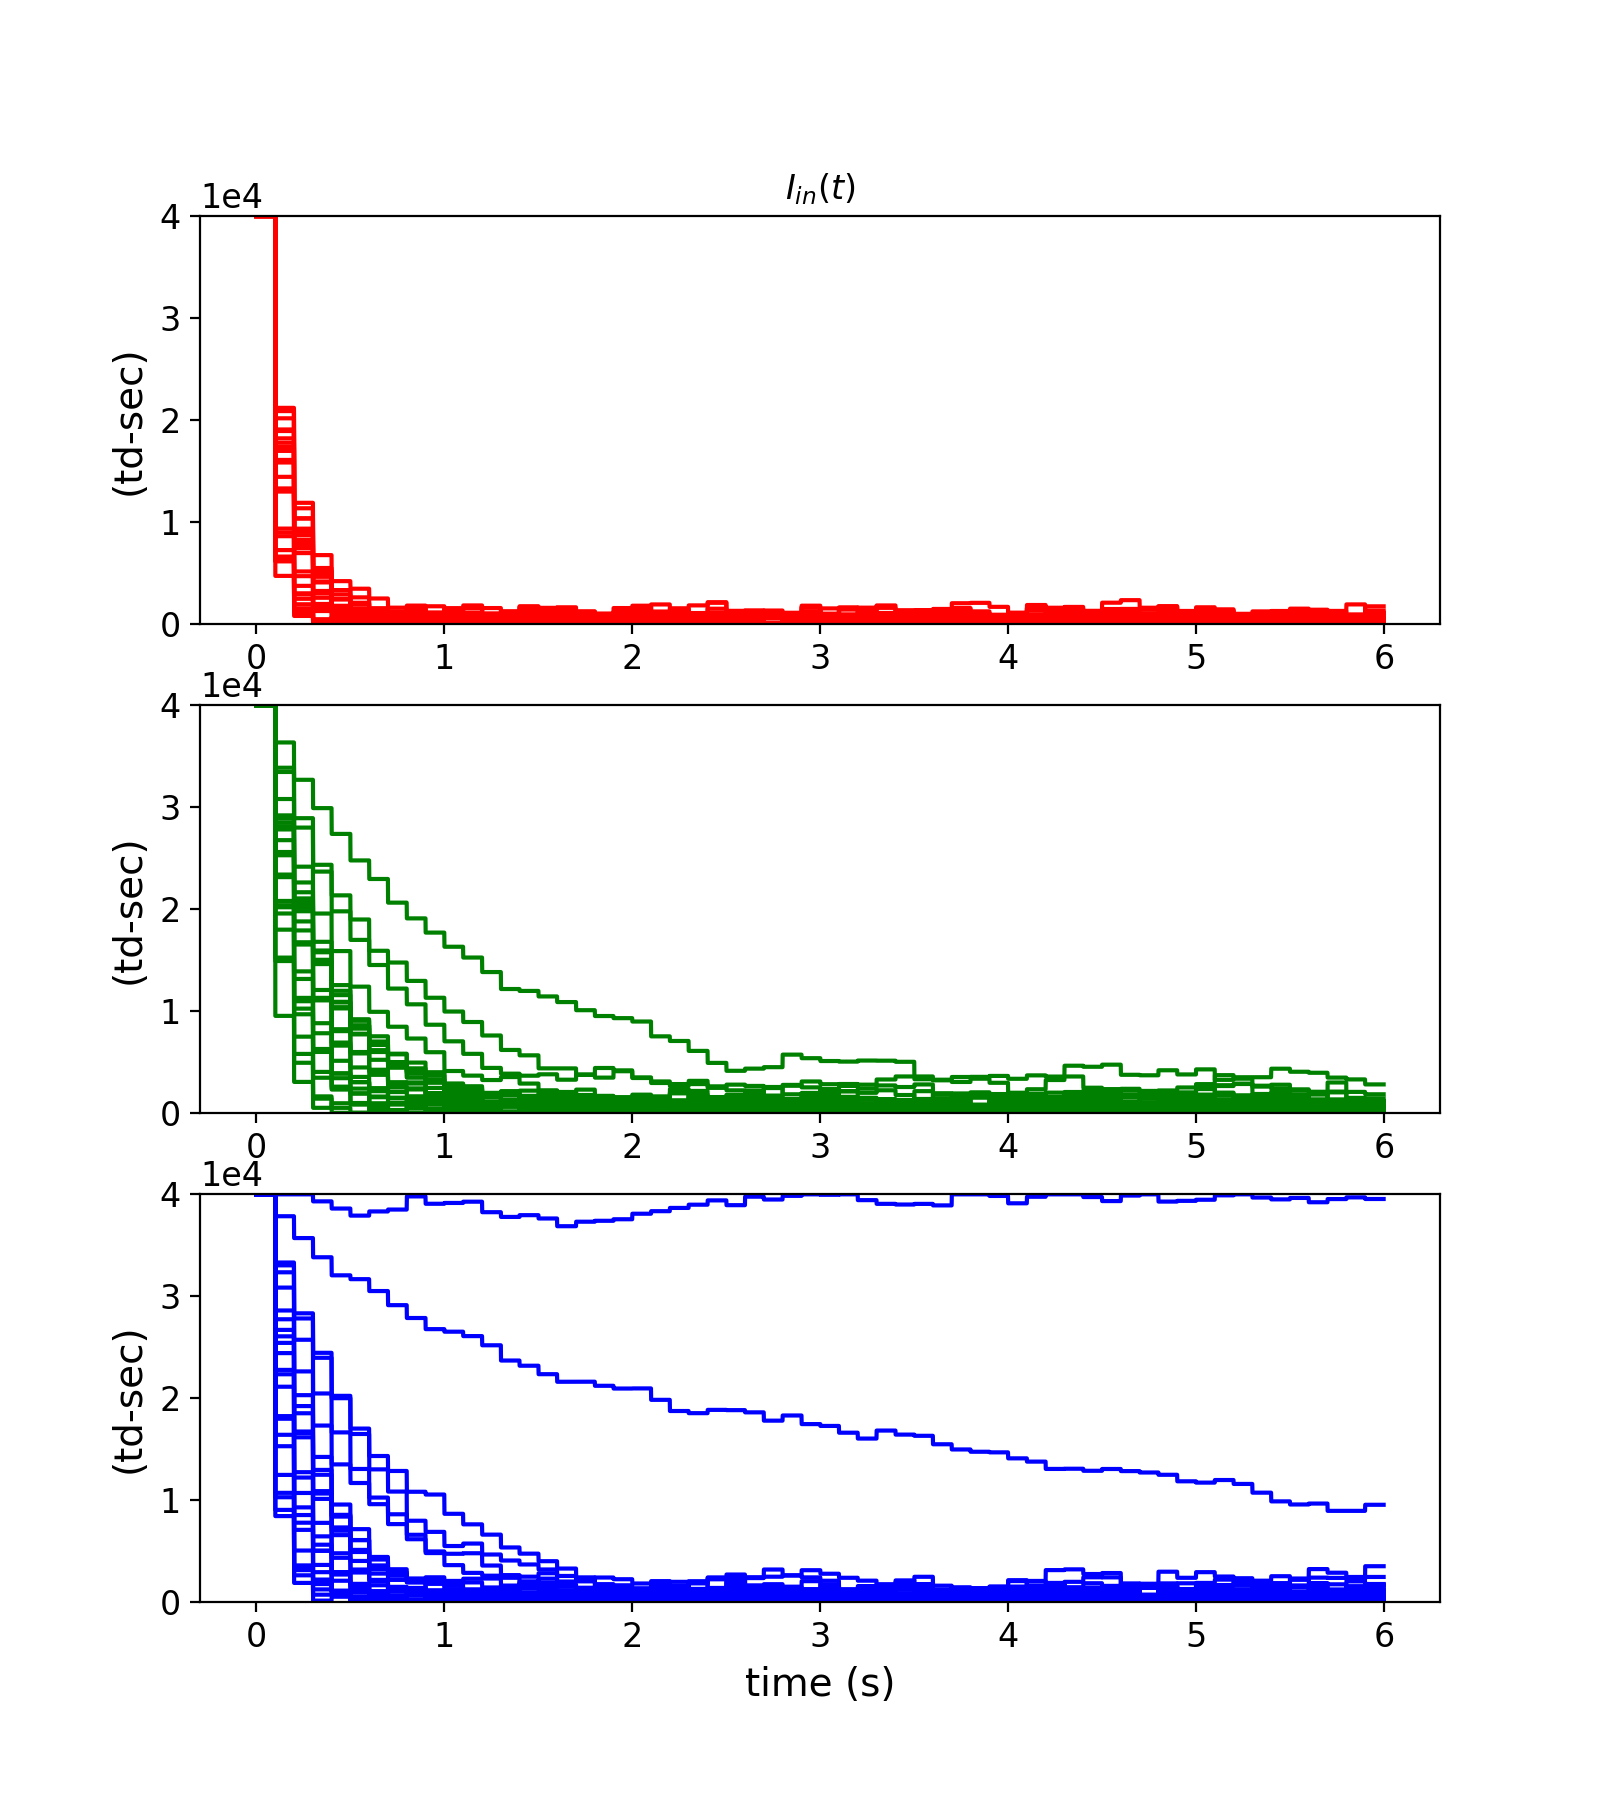

<IPython.core.display.Javascript object>


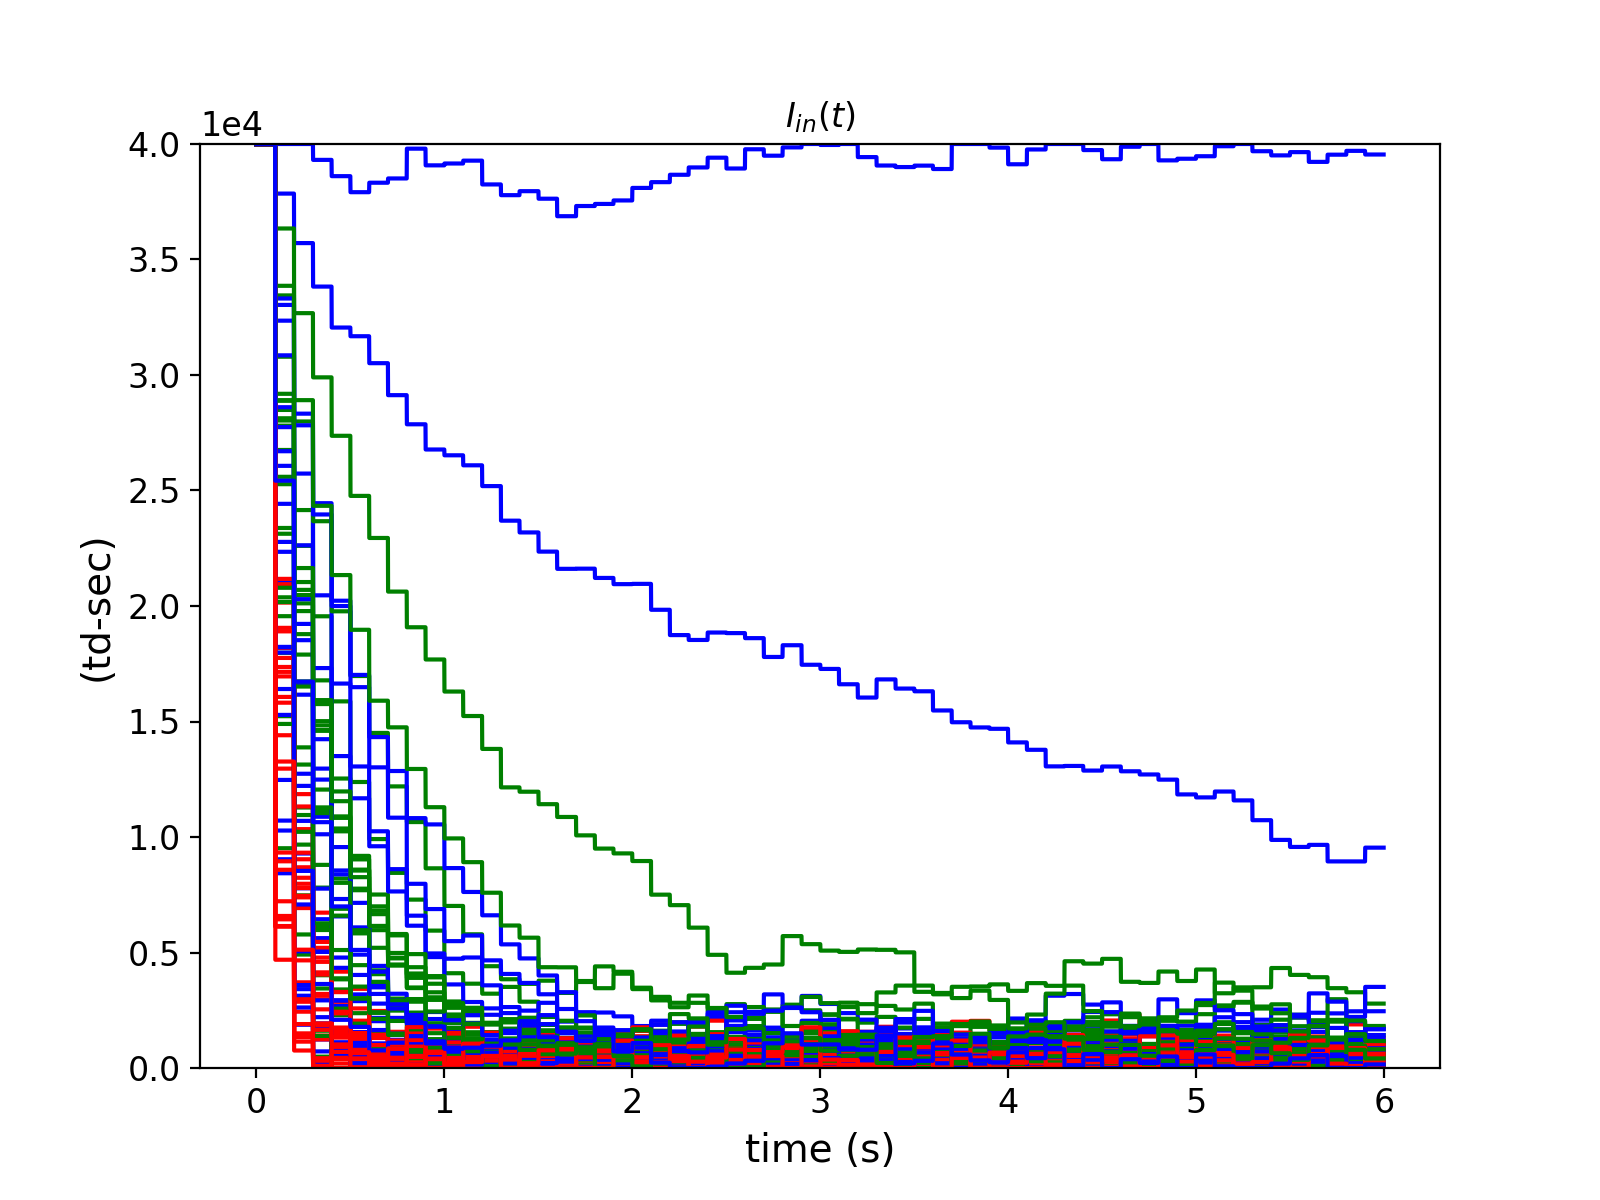

Text(0.5, 0, 'time (s)')

In [25]:
# qt, wx, gtk, osx, tk, empty uses default
%matplotlib notebook 

ylim = 4e4

plt.figure(figsize=(8, 9), dpi=100)
plt.subplot(3,1,1)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for i in range(n_trials):
    plt.plot(t, L_Iin_all[i,:-1],c='r')
plt.title('$I_{in}(t)$')
plt.ylim([0, ylim])
plt.ylabel('(td-sec)')

plt.subplot(3,1,2)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for i in range(n_trials):
    plt.plot(t, M_Iin_all[i,:-1],c='g')
plt.ylim([0, ylim])
plt.ylabel('(td-sec)')

plt.subplot(3,1,3)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for i in range(n_trials):
    plt.plot(t, S_Iin_all[i,:-1],c='b')
plt.ylim([0, ylim])
plt.ylabel('(td-sec)')
plt.xlabel('time (s)')

plt.figure(figsize=(8, 6), dpi=100)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for i in range(n_trials):
    plt.plot(t, L_Iin_all[i,:-1],c='r')
    plt.plot(t, M_Iin_all[i,:-1],c='g')
    plt.plot(t, S_Iin_all[i,:-1],c='b')
    
plt.title('$I_{in}(t)$')
plt.ylim([0, ylim])
plt.ylabel('(td-sec)')
plt.xlabel('time (s)')

## Run experiment with $\alpha_{scatter}$ estimation

In [26]:
# simulation settings
n_trials = 25

L_Iin_all, L_Iout_all, L_pt_all, L_resid_all = [],[],[],[]
M_Iin_all, M_Iout_all, M_pt_all, M_resid_all = [],[],[],[]
S_Iin_all, S_Iout_all, S_pt_all, S_resid_all = [],[],[],[]

for i in range(n_trials):
    L_Iin, L_Iout, L_pt, t, L_resid = opticalfeedback.simulate(a_cone=c.cone_L(lmbda), account_for_a_scatter=True, \
                                                               a_scatter_bounds=(0.2,1))
    M_Iin, M_Iout, M_pt, t, M_resid = opticalfeedback.simulate(a_cone=c.cone_M(lmbda), account_for_a_scatter=True, \
                                                               a_scatter_bounds=(0.2,1))
    S_Iin, S_Iout, S_pt, t, S_resid = opticalfeedback.simulate(a_cone=c.cone_S(lmbda), account_for_a_scatter=True, \
                                                               a_scatter_bounds=(0.2,1))
    
    append_four(L_Iin, L_Iout, L_pt, L_resid, L_Iin_all, L_Iout_all, L_pt_all, L_resid_all)
    append_four(M_Iin, M_Iout, M_pt, M_resid, M_Iin_all, M_Iout_all, M_pt_all, M_resid_all)
    append_four(S_Iin, S_Iout, S_pt, S_resid, S_Iin_all, S_Iout_all, S_pt_all, S_resid_all)
    
L_Iin_all, L_Iout_all, L_pt_all, L_resid_all = convert_to_np(L_Iin_all, L_Iout_all, L_pt_all, L_resid_all)
M_Iin_all, M_Iout_all, M_pt_all, M_resid_all = convert_to_np(M_Iin_all, M_Iout_all, M_pt_all, M_resid_all)
S_Iin_all, S_Iout_all, S_pt_all, S_resid_all = convert_to_np(S_Iin_all, S_Iout_all, S_pt_all, S_resid_all)
    
print('L-cone intrinsic residual ~ mean: %0.2e ~ std: %0.2e' % 
      (np.mean(L_resid_all), np.std(L_resid_all)))
print('M-cone intrinsic residual ~ mean: %0.2e ~ std: %0.2e' % 
      (np.mean(M_resid_all), np.std(M_resid_all)))
print('S-cone intrinsic residual ~ mean: %0.2e ~ std: %0.2e' % 
      (np.mean(S_resid_all), np.std(S_resid_all)))

L-cone intrinsic residual ~ mean: 8.99e-04 ~ std: 4.75e-04
M-cone intrinsic residual ~ mean: 7.62e-04 ~ std: 5.50e-04
S-cone intrinsic residual ~ mean: 6.61e-04 ~ std: 4.47e-04


<IPython.core.display.Javascript object>


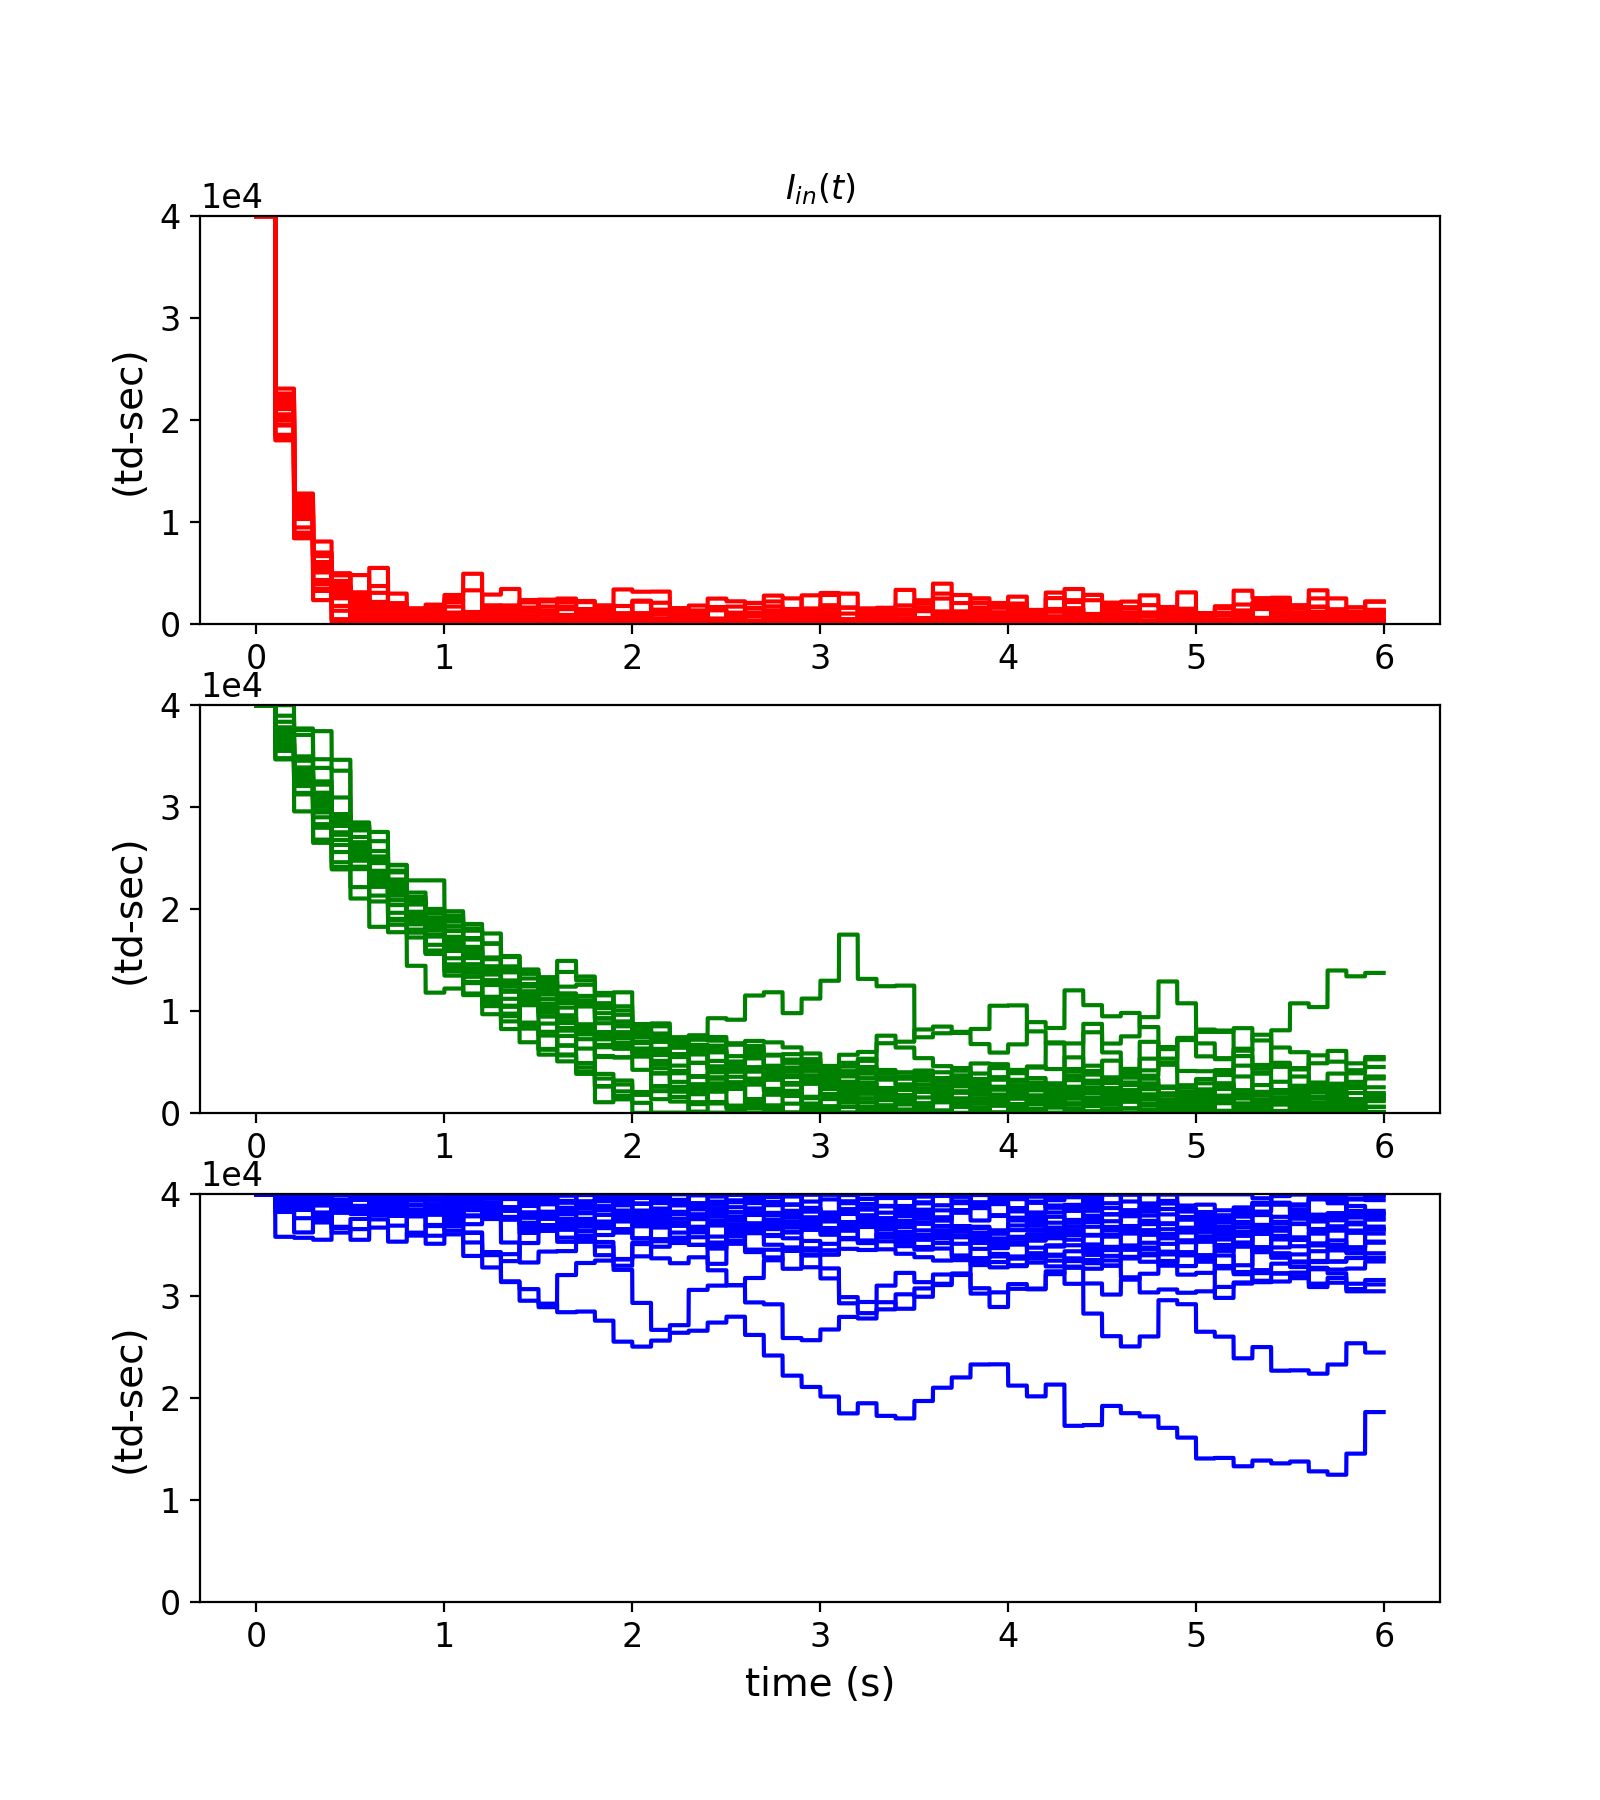

<IPython.core.display.Javascript object>


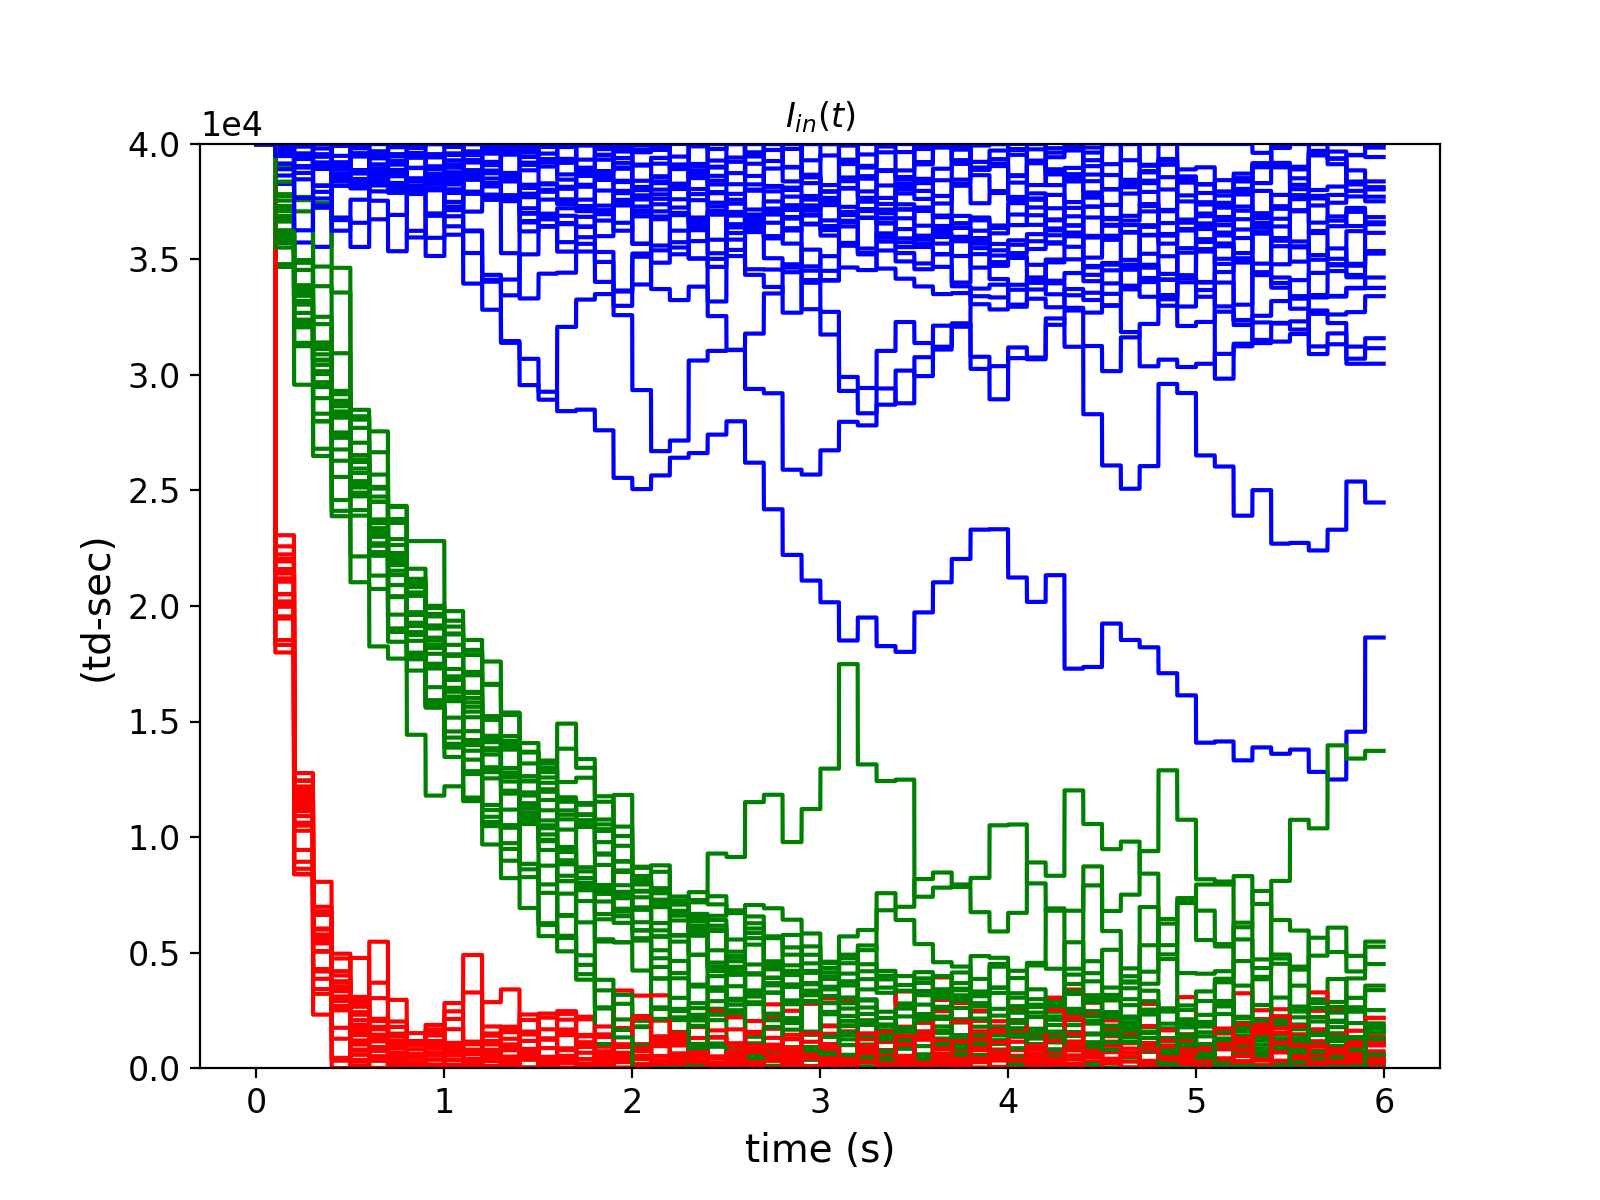

Text(0.5, 0, 'time (s)')

In [27]:
# qt, wx, gtk, osx, tk, empty uses default
%matplotlib notebook 

ylim = 4e4

plt.figure(figsize=(8, 9), dpi=100)
plt.subplot(3,1,1)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for i in range(n_trials):
    plt.plot(t, L_Iin_all[i,:-1],c='r')
plt.title('$I_{in}(t)$')
plt.ylim([0, ylim])
plt.ylabel('(td-sec)')

plt.subplot(3,1,2)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for i in range(n_trials):
    plt.plot(t, M_Iin_all[i,:-1],c='g')
plt.ylim([0, ylim])
plt.ylabel('(td-sec)')

plt.subplot(3,1,3)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for i in range(n_trials):
    plt.plot(t, S_Iin_all[i,:-1],c='b')
plt.ylim([0, ylim])
plt.ylabel('(td-sec)')
plt.xlabel('time (s)')

plt.figure(figsize=(8, 6), dpi=100)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for i in range(n_trials):
    plt.plot(t, L_Iin_all[i,:-1],c='r')
    plt.plot(t, M_Iin_all[i,:-1],c='g')
    plt.plot(t, S_Iin_all[i,:-1],c='b')
    
plt.title('$I_{in}(t)$')
plt.ylim([0, ylim])
plt.ylabel('(td-sec)')
plt.xlabel('time (s)')

### In the above model, we see that correcting for the inherent scatter made the input image diverge from the other cones! This should allow us to cluster the curves and infer L-types easily.

<IPython.core.display.Javascript object>


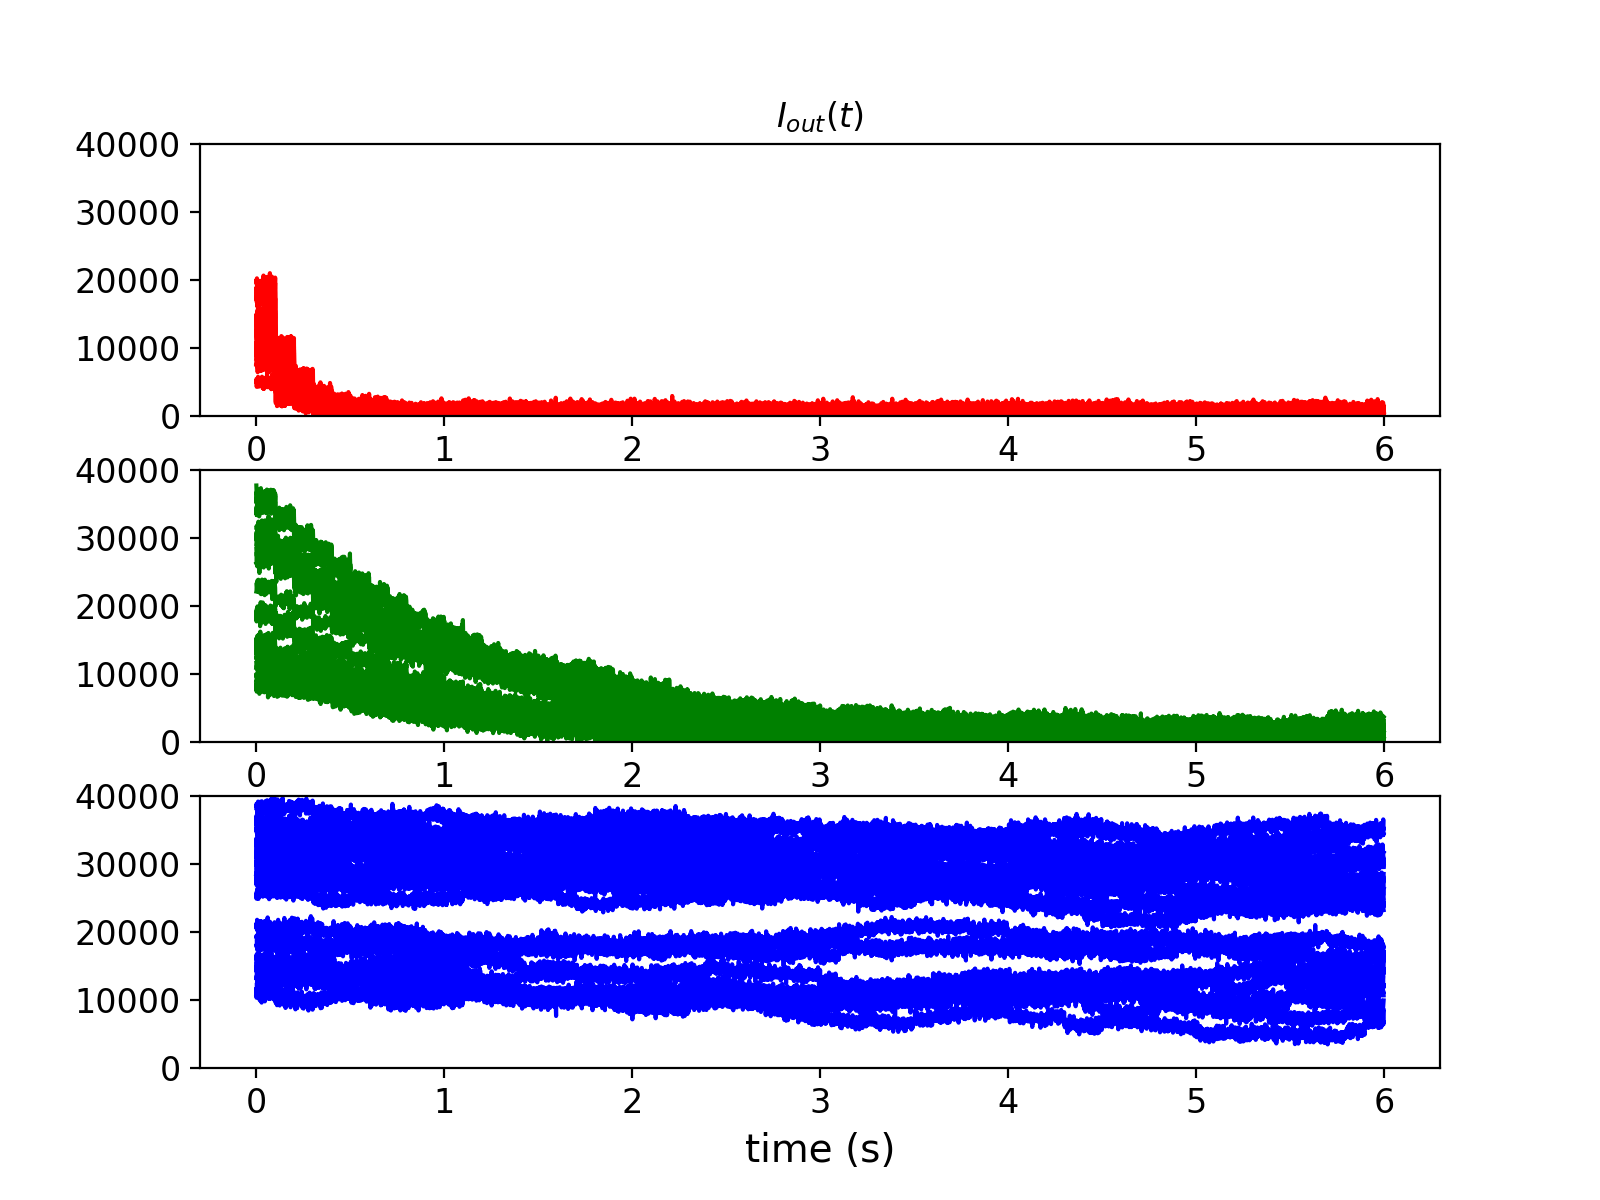

Text(0.5, 0, 'time (s)')

In [28]:
%matplotlib notebook

plt.figure(figsize=(8, 6), dpi=100)
plt.subplot(3,1,1)
for i in range(n_trials):
    plt.plot(t, L_Iout_all[i,:],c='r')
plt.ylim([0, 4e4])
plt.title('$I_{out}(t)$')

plt.subplot(3,1,2)
for i in range(n_trials):
    plt.plot(t, M_Iout_all[i,:],c='g')
plt.ylim([0, 4e4])
    
plt.subplot(3,1,3)
for i in range(n_trials):
    plt.plot(t, S_Iout_all[i,:],c='b')
plt.ylim([0, 4e4])
plt.xlabel('time (s)')